<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/bayesian-networks/bayesian_networks_pyagrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Networks Titanic

In [1]:
!pip install -q pyagrum

     |████████████████████████████████| 4.5MB 5.1MB/s 


In [0]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import os
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from IPython.display import Image

The goal here is not to produce the best possible classifier, at least not yet, but to show how pyAgrum and Bayesian Networks can be used to easily and quickly explore and understand data.

This notebook present three different Bayesien Networks techniques to answer the Kaggle Titanic challenge. The first approach we will answer the challenge without using the training set and we will only use our prior knowledge about shipwrecks. In the second approach we will only use the training set with pyAgrum's machine learning algorithms. Finally, in the third approach we will use both prior knowledge about shipwrecks and machine learning.

## Preprocessing

In [3]:
!pip install -q kaggle
from google.colab import drive
drive.mount('/content/gdrive')
!mkdir -p ~/.kaggle
!cp /content/gdrive/My\ Drive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic
!ls -l /content

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 6.46MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 28.6MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 61.5MB/s]
total 100
drwx------ 4 root root  4096 Feb 10 06:09 gdrive
-rw-r--r-- 1 root root  3258 Feb 10 06:09 gender_submission.csv
drwxr-xr-x 1 root root  4096 Feb  5 18:37 sample_data
-rw-r--r-- 1 root root 28629 Feb 10 06:09 test.csv
-rw-r--r-- 1 roo

## Create the network topology

In [4]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('test.csv')
gender_df = pd.read_csv('gender_submission.csv')
test_df = pd.merge(val_df, gender_df, on='PassengerId')
del val_df
del gender_df
test_df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1


In [0]:
def forAge(row):
    try:
        age = float(row['Age'])
        if age < 1:
            #return '[0;1['
            return 'baby'
        elif age < 6:
            #return '[1;6['
            return 'toddler'
        elif age < 12:
            #return '[6;12['
            return 'kid'
        elif age < 21:
            #return '[12;21['
            return 'teen'
        elif age < 80:
            #return '[21;80['
            return 'adult'
        else:
            #return '[80;200]'
            return 'old'
    except ValueError:
        return np.nan
    
def forBoolean(row, col):
    try:
        val = int(row[col])
        if row[col] >= 1:
            return "True"
        else:
            return "False"
    except ValueError:
        return "False"
    
def forGender(row):
    if row['Sex'] == "male":
        return "Male"
    else:
        return "Female"
        

In [0]:
def pretreat(df):
    if 'Survived' in df.columns:
        df['Survived'] = df.apply(lambda row: forBoolean(row, 'Survived'), axis=1).dropna()
    df['Age'] = df.apply(forAge, axis=1).dropna()
    df['SibSp'] = df.apply(lambda row: forBoolean(row, 'SibSp'), axis=1).dropna()
    df['Parch'] = df.apply(lambda row: forBoolean(row, 'Parch'), axis=1).dropna()
    df['Sex'] = df.apply(forGender, axis=1).dropna()
    unique_counts = df.apply(pd.Series.nunique)
    target_keys = unique_counts[unique_counts <= 15].keys()
    df = df[target_keys]
    df = df.rename(index=str, 
                   columns={'Sex': 'Gender', 'SibSp': 'Siblings', 'Parch': 
                            'Parents'})
    return df

In [7]:
train_df = pretreat(train_df)
train_df.head(3)

,Survived,Pclass,Gender,Age,Siblings,Parents,Embarked
0,False,3,Male,adult,True,False,S
1,True,1,Female,adult,True,False,C
2,True,3,Female,adult,False,False,S


In [8]:
test_df = pretreat(test_df)
test_df.head(3)

,Pclass,Gender,Age,Siblings,Parents,Embarked,Survived
0,3,Male,adult,False,False,Q,False
1,3,Female,adult,True,False,S,True
2,2,Male,adult,False,False,Q,False


# Modeling without learning

In some cases, we might not have any data to learn from. In such cases, we can rely on experts to provide correlation between variables and conditional probabilities.

It can be simpler to start with a simple topography, leaving room to add more complexe correlations as the model is confonted aginst data. Here, we will use three hypothesis:

- All variables are independent conditionnaly to each other given the fact that a passenger has survive or not.
- Women and children are more likelly to survive.
- The more sibling or parents abord, the less likelly the passenger will survive.



In [12]:
bn = gum.BayesNet('Surviving Titanic')
bn = gum.fastBN('Age{baby|toddler|kid|teen|adult|old}<-Survived{False|True}->Gender{Female|Male};Siblings{False|True}<-Survived->Parents{False|True}')
print(bn.variable('Survived'))
print(bn.variable('Age'))
print(bn.variable('Gender'))
print(bn.variable('Siblings'))
print(bn.variable('Parents'))
bn

Survived<False,True>
Age<baby,toddler,kid,teen,adult,old>
Gender<Female,Male>
Siblings<False,True>
Parents<False,True>


(gum::BayesNet<double>@0x4ac2600) BN{nodes: 5, arcs: 4, domainSize: 96, dim: 26}

In [15]:
bn.cpt('Survived')[:] = [100, 1]
bn.cpt('Survived').normalizeAsCPT()
bn.cpt('Survived')

(gum::Potential<double>@0x4bb7d00) <Survived:False> :: 0.990099 /<Survived:True> :: 0.00990099

In [16]:
bn.cpt('Age')[0] = [ 1, 1, 1, 10, 10, 1]
bn.cpt('Age')[1] = [ 10, 10, 10, 1, 1, 10]
bn.cpt('Age').normalizeAsCPT()
bn.cpt('Age')

(gum::Potential<double>@0x4bb7b40) <Age:baby|Survived:False> :: 0.0416667 /<Age:toddler|Survived:False> :: 0.0416667 /<Age:kid|Survived:False> :: 0.0416667 /<Age:teen|Survived:False> :: 0.416667 /<Age:adult|Survived:False> :: 0.416667 /<Age:old|Survived:False> :: 0.0416667 /<Age:baby|Survived:True> :: 0.238095 /<Age:toddler|Survived:True> :: 0.238095 /<Age:kid|Survived:True> :: 0.238095 /<Age:teen|Survived:True> :: 0.0238095 /<Age:adult|Survived:True> :: 0.0238095 /<Age:old|Survived:True> :: 0.238095

In [17]:
bn.cpt('Gender')[0] = [ 1, 1]
bn.cpt('Gender')[1] = [ 10, 1]
bn.cpt('Gender').normalizeAsCPT()
bn.cpt('Gender')

(gum::Potential<double>@0x4bb7aa0) <Gender:Female|Survived:False> :: 0.5 /<Gender:Male|Survived:False> :: 0.5 /<Gender:Female|Survived:True> :: 0.909091 /<Gender:Male|Survived:True> :: 0.0909091

In [18]:
bn.cpt('Siblings')[0] = [ 1, 10]
bn.cpt('Siblings')[1] = [ 10, 1]
bn.cpt('Siblings').normalizeAsCPT()
bn.cpt('Siblings')

(gum::Potential<double>@0x4bb7de0) <Siblings:False|Survived:False> :: 0.0909091 /<Siblings:True|Survived:False> :: 0.909091 /<Siblings:False|Survived:True> :: 0.909091 /<Siblings:True|Survived:True> :: 0.0909091

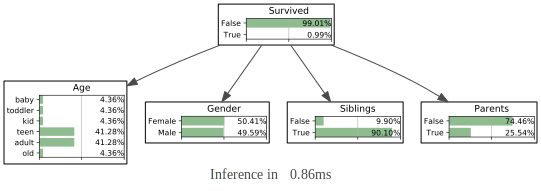

In [19]:
gnb.showInference(bn,size="10")

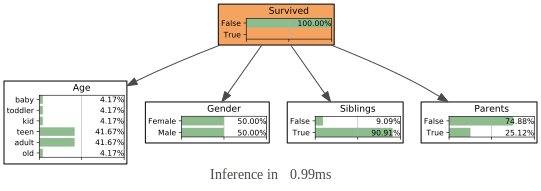

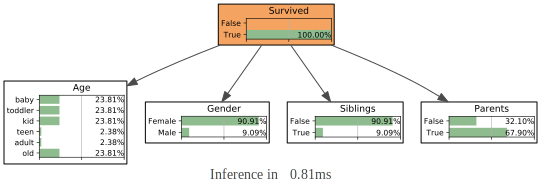

In [20]:
gnb.showInference(bn,size="10", evs={'Survived':'False'})
gnb.showInference(bn,size="10", evs={'Survived':'True'})

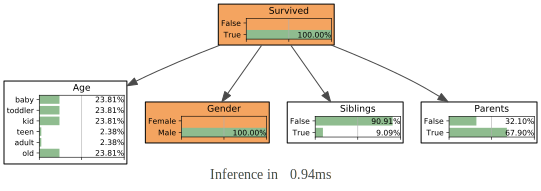

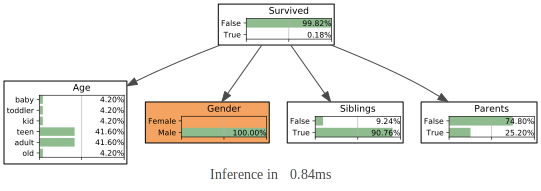

In [21]:
gnb.showInference(bn,size="10", evs={'Survived':'True', 'Gender':'Male'})
gnb.showInference(bn,size="10", evs={'Gender':'Male'})